In [14]:
# in the number of crashes in NSW and speed cameras

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
from scipy.stats import chi2_contingency
import requests
import time
from pathlib import Path
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import hvplot.pandas


# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# File to Load 
crash_data_path = ("Resources/CSV_CRASH_DATA.csv")

# Assign csv info into crash_data 
crash_data = pd.read_csv(crash_data_path)

crash_data


,Crash ID,Degree of crash,Degree of crash - detailed,Reporting year,Year of crash,Month of crash,Day of week of crash,Two-hour intervals,Street of crash,Street type,...,DCA - description,DCA supplement,First impact type,Key TU type,Other TU type,No. of traffic units involved,No. killed,No. seriously injured,No. moderately injured,No. minor-other injured
0,1151002,Non-casualty (towaway),Non-casualty (towaway),2018,2018,February,Thursday,06:00 - 07:59,SACKVILLE,ST,...,Manov - Reverse in traffic,NaN,Other angle,Car (sedan/hatch),Car (sedan/hatch),3,0,0,0,0
1,1158000,Fatal,Fatal,2018,2018,January,Monday,00:01 - 01:59,BRUNKER,RD,...,On path - Parked,NaN,Other angle,Car (sedan/hatch),Light truck utility(from 2018),2,1,2,0,0
2,1158001,Fatal,Fatal,2018,2018,January,Monday,08:00 - 09:59,CLARENCE,WAY,...,Off left bend into obj,Right,Vehicle - Object,Car (sedan/hatch),NaN,1,1,0,0,0
3,1158002,Fatal,Fatal,2018,2018,January,Monday,02:00 - 03:59,RAILWAY,RD,...,Ped - On carriageway,NaN,Vehicle - Pedestrian,Car (sedan/hatch),Pedestrian,2,1,0,0,0
4,1158515,Fatal,Fatal,2018,2018,January,Tuesday,20:00 - 21:59,CHRISTINA,RD,...,Ped - Far side,NaN,Vehicle - Pedestrian,Car (sedan/hatch),Pedestrian,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95868,1325645,Non-casualty (towaway),Non-casualty (towaway),2022,2022,September,Sunday,16:00 - 17:59,NEW ENGLAND,HWY,...,Left off cway into object,NaN,Vehicle - Object,4 wheel drive,NaN,1,0,0,0,0
95869,1327398,Injury,Minor/Other Injury,2022,2022,October,Monday,14:00 - 15:59,GIINAGAY,WAY,...,Adj - Right-thru from right,NaN,Right angle,4 wheel drive,Large rigid,2,0,0,0,1
95870,1328035,Non-casualty (towaway),Non-casualty (towaway),2022,2022,December,Saturday,16:00 - 17:59,KYOGLE,RD,...,Off right bend into obj,Left,Vehicle - Object,Light truck utility(from 2018),NaN,1,0,0,0,0
95871,1328036,Injury,Minor/Other Injury,2022,2022,October,Tuesday,10:00 - 11:59,AVOCA,DR,...,Ovtak - Head on,NaN,Head-on,Light truck utility(from 2018),4 wheel drive,2,0,0,0,3


In [3]:
#Dropping unwanted columns 
clean_crash_data = crash_data.drop(columns=[
    "Street of crash",
    "Street type",
    "DCA supplement",
    "Key TU type",
    "Other TU type",
    "Reporting year",
    "Street of crash",
    "Street type",
    "Distance",
    "Direction",
    "Identifying feature",
    "Identifying feature type",
    "Key TU type",
    "Route no.",
    "School zone location",
    "School zone active",
    "Type of location",
    "LGA",
    "Urbanisation",
    "Conurbation 1",
    "Alignment",
    "Primary permanent feature",
    "Primary temporary feature",
    "Primary hazardous feature",
    "Signals operation",
    "Other traffic control",
    "RUM - description",
    "DCA - code",
    "DCA - description",
    "DCA supplement",
    "No. of traffic units involved",
    "Degree of crash - detailed",
    "Street lighting",
    "Road surface",
    "Surface condition",
    "Weather",
    "Road classification (admin)",	
    "First impact type",
    "No. killed",
    "No. seriously injured",
    "No. moderately injured",
    "No. minor-other injured",
    "Two-hour intervals",
    "Year of crash",
    "Degree of crash",
    "Month of crash",	
    "Day of week of crash",

])

clean_crash_data
random_clean_data = clean_crash_data.sample(n=103)
random_clean_data

,Crash ID,Town,Latitude,Longitude,Natural lighting,Speed limit,RUM - code
60326,1254021,CHINDERAH,-28.267217,153.510590,Daylight,100 km/h,35
51162,1239256,GOULBURN,-34.743872,149.722873,Daylight,50 km/h,30
71422,1272370,TINTENBAR,-28.790246,153.524958,Daylight,110 km/h,86
85147,1294413,BONNYRIGG,-33.885448,150.891463,Daylight,50 km/h,87
39995,1221593,SACKVILLE,-33.503296,150.863168,Daylight,70 km/h,13
...,...,...,...,...,...,...,...
60425,1254183,NORTH BONDI,-33.886141,151.284314,Daylight,50 km/h,30
32050,1209087,SYDNEY,-33.863616,151.208943,Daylight,40 km/h,0
5473,1169313,LEEVILLE,-28.981465,153.009433,Daylight,100 km/h,21
51729,1240195,ALEXANDRIA,-33.906162,151.202153,Daylight,50 km/h,11


In [4]:
# raw data files
ardd_path = "Resources/fixed-speed-cameras_1.csv"

# assign csv info into ardd
ardd = pd.read_csv(ardd_path,header=0,low_memory=False, dtype={"SZ?": "string",
                                                               "SUBURB/TOWN": "string",
                                                               "ROAD/S": "string",
                                                               "Cameras": "string" })
                                                                

# preview data
ardd
# rename df
Speed_camera = ardd.rename(columns={'SUBURB/TOWN': 'Suburb', 'ROAD/S': 'Road', 'Lat(1)': 'Lat', 'Long(1)': 'Long'})
Speed_camera.head()

,SZ?,Suburb,Road,Cameras,Lat,Long,Lat(2),Long(2)
0,Y,Ashfield,"Hume Highway, between Murrell Street and Queen...",1,-33.890177,151.127985,NaN,NaN
1,N,Auburn,"Parramatta Road, between Harbord Street and Du...",1,-33.835963,151.023621,NaN,NaN
2,Y,Bankstown,"Hume Highway, between Rookwood Road and Stacey...",2,-33.905919,151.038598,-33.906183,151.038915
3,N,Bar Point,"M1, between Jolls Bridge and Mt White Exit Ramp",1,-33.488208,151.183867,NaN,NaN
4,N,Ben Lomond,"New England Highway, between Ross Road and Ben...",1,-30.006089,151.715005,NaN,NaN


The r^value is: 0.00666341


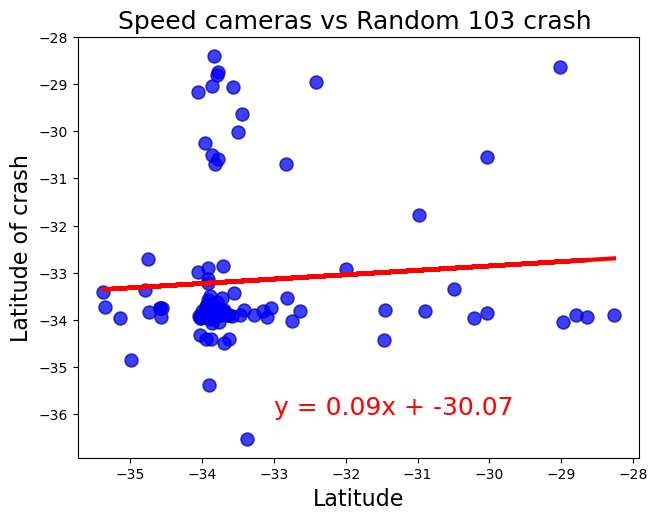

In [5]:
# Compute Linear Regression for Each Relationship
# Define a function to create Linear Regression plots
def linearRegression(x_values,y_values, regEQplotX, regEQplotY, ylabel):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, 80, marker="o", facecolors="blue", alpha=0.5)
    plt.plot(x_values,regress_values,"r-", linewidth=3)
    plt.grid(True)
    print(f'The r^value is: {round(rvalue**2, 8)}')
    plt.annotate(line_eq,(regEQplotX,regEQplotY),fontsize=18,color="red")
    plt.xlabel('Latitude', fontsize=16)
    plt.ylabel(f'{ylabel}', fontsize=16)
# Build scatter plot for latitude Speed Camera vs. latitude Red light Camera
# Plot main data
xPlot = random_clean_data["Latitude"]
yPlot = Speed_camera["Lat"]
plt.scatter(xPlot, yPlot, 90, marker="o", facecolors="b", edgecolors='black', alpha=0.5)
plt.tight_layout()
# Plot output and styling
# Incorporate the other graph properties
plt.xlabel("Latitude random 103 crash ", fontsize=16)
plt.ylabel("Latitude of speed cameras", fontsize=16)
plt.title("Speed cameras vs Random 103 crash ", fontsize=18)
linearRegression(xPlot, yPlot, -33, -36, "Latitude of crash")
plt.grid() 
plt.savefig("output_data/Fig1.png",dpi=300, bbox_inches = "tight")
# Save the figure

# Show plot
plt.show()

In [ ]:
# No linear relationship. It is mean, my random crashes were happed not near the speed camera. It is mean the speed camepa help to avoid crash.

In [6]:
# Mpping the Cameras
map_plot_1 = Speed_camera.hvplot.points(
    "Long",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width=800, 
    frame_height=500,
    size = 80,
    hover_cols = ["Suburb", "Road"])

# Display the map plot_1
map_plot_1

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Long,Lat]   (Suburb,Road)

In [7]:
# Mapping the crashes on a road NSW
map_plot_2 = random_clean_data.hvplot.points(
    "Longitude",
    "Latitude",
    
    geo = True,
    tiles = "OSM",
    frame_width=800, 
    frame_height=500,
    scale = 2,
    size = "RUM - code",
    hover_cols = ["Town"],
    color = "red"
)

# Display the map plot_2
map_plot_2

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (RUM - code,Town)